<a href="https://colab.research.google.com/github/SLVmain/Neural_Network_start/blob/Les_03/HW_03_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в искусственные нейронные сети
# Урок 3. TensorFlow

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews .Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    

In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
print(tf.__version__)
msg = tf.constant('TensorFlow 2.0 Hello World')
tf.print(msg)

2.7.0
TensorFlow 2.0 Hello World


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных

In [ ]:
import warnings
from sklearn.datasets import load_boston
with warnings.catch_warnings():
 # You should probably not use this dataset.
  warnings.filterwarnings("ignore")
  boston_data = load_boston()

In [ ]:
print(boston_data.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])


In [ ]:
X = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
y = pd.DataFrame(boston_data.target, columns =['target'])
y[:5]

,target
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


# Предобработка данных

In [ ]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [ ]:
X_nunique

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [ ]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
f_all = set(X_nunique.index.tolist())
f_binary = set(X.loc[:, f_all].columns[(
                      (X.loc[:, f_all].max() == 1) & \
                      (X.loc[:, f_all].min() == 0) & \
                      (X.loc[:, f_all].isnull().sum() == 0))])
f_categorical = set(X_nunique.loc[f_all][X_nunique.loc[f_all] <= 10].index.tolist())
f_numeric = f_all -  f_categorical
print('f_all:', X.shape[1])
print('f_binary:', f_binary)
print('f_categorical:', f_categorical)
print('f_numeric:', f_numeric)


f_all: 13
f_binary: {'CHAS'}
f_categorical: {'CHAS', 'RAD'}
f_numeric: {'PTRATIO', 'NOX', 'LSTAT', 'DIS', 'RM', 'AGE', 'TAX', 'CRIM', 'B', 'ZN', 'INDUS'}


видим, что у нас два признака с небольшим числом уникальных значений, один из них бинарный

обработаем данные: категориальные:  OHE, численные - стандартизация

In [ ]:
from sklearn import preprocessing

for feature in X.columns:
    if feature not in f_categorical:
      X[feature] = preprocessing.scale(X[feature])

In [ ]:
X = pd.get_dummies(X, columns=f_categorical)
X.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,CHAS_0.0,CHAS_1.0,RAD_1.0,RAD_2.0,RAD_3.0,RAD_4.0,RAD_5.0,RAD_6.0,RAD_7.0,RAD_8.0,RAD_24.0
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.666608,-1.459000,0.441052,-1.075562,1,0,1,0,0,0,0,0,0,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.987329,-0.303094,0.441052,-0.492439,1,0,0,1,0,0,0,0,0,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.987329,-0.303094,0.396427,-1.208727,1,0,0,1,0,0,0,0,0,0,0
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-1.106115,0.113032,0.416163,-1.361517,1,0,0,0,1,0,0,0,0,0,0
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-1.106115,0.113032,0.441052,-1.026501,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
X[f_numeric].describe().transpose()[['mean', 'std']]

,mean,std
PTRATIO,4.493551e-16,1.00099
NOX,-8.071058e-16,1.00099
LSTAT,-1.595123e-16,1.00099
DIS,8.293761e-17,1.00099
RM,-5.189086e-17,1.00099
AGE,-2.650493e-16,1.00099
TAX,-9.934960e-16,1.00099
CRIM,-8.513173e-17,1.00099
B,-1.451408e-16,1.00099
ZN,3.306534e-16,1.00099


In [ ]:
# для Y используем StandardScaler(), для удобства пересчета результата в исходное измерение
from sklearn.preprocessing import StandardScaler

MyScaler = StandardScaler()

y_scaled = MyScaler.fit_transform(y)

#проверка
y_unscaled = MyScaler.inverse_transform(y_scaled).flatten()

#print(np.array(y).flatten() == y_unscaled)
# не все true, видимо, из-за округлений
print(np.where(np.array(y).flatten() != y_unscaled))
for i in np.where(np.array(y).flatten() != y_unscaled):
  print(np.array(y).flatten()[i])
  print(y_unscaled[i])


(array([382, 385, 397, 399, 400, 401, 404, 415, 446, 447, 454, 458]),)
[11.3  7.2  8.5  6.3  5.6  7.2  8.5  7.2 14.9 12.6 14.9 14.9]
[11.3  7.2  8.5  6.3  5.6  7.2  8.5  7.2 14.9 12.6 14.9 14.9]


In [ ]:
#Преобразуем данные в np.array для загрузки в сеть

X_train = np.array(X.values)
print(X_train.shape)
print(y_scaled.shape)

(506, 22)
(506, 1)


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(X_train, y_scaled, test_size=0.2, shuffle=True)

# Построение сети

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow import keras
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()


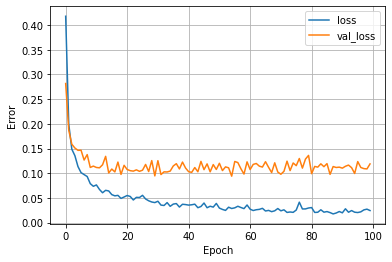

In [ ]:
# base line
metrics_list = []
metrics = [tf.keras.metrics.MeanSquaredError(), 
           tf.keras.metrics.MeanAbsoluteError(), 
           #tf.keras.metrics.MeanAbsolutePercentageError(),
           ]

x_input = keras.layers.Input(shape=(x_tr.shape[1],))
x2 = keras.layers.Dense(900, activation='relu')(x_input)
x_output = keras.layers.Dense(1, activation='linear')(x2)

model2=keras.models.Model(x_input,x_output) 

model2.compile(optimizer='adam',
                      loss='mse',
                      metrics=metrics)

history2 = model2.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)
  
metrics_list = metrics_list + [['1','900', 'mse', 'relu', 'adam', round(history2.history['loss'][-1], 3), round(model2.evaluate(x_test, y_test, verbose = 0)[1], 3)]]
  
plot_loss(history2)

In [ ]:
df = pd.DataFrame(metrics_list, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mse','val_mse'], index =None)
df

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
0,1,900,mse,relu,adam,0.024,0.159


In [ ]:
N = [2, 3, 5, 10] # Кол-во слоев
for i in N:
    model1 = Sequential() 
    model1.add(Dense(900, activation='relu', input_shape=(x_tr.shape[1],)))
    

    for k in range(i):
      model1.add(Dense(100, activation='relu')) 
    
    
    model1.add(Dense(1, activation='linear'))


    model1.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse', 'mae']) 

    history1 = model1.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)

    metrics_list = metrics_list + [[i, '100', 'mse', 'relu', 'adam', round(history1.history['loss'][-1], 3), round(model1.evaluate(x_test, y_test, verbose = 0)[1], 3)]]


In [ ]:
df = pd.DataFrame(metrics_list, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mse','val_mse'], index =None)
df

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
0,1,900,mse,relu,adam,0.024,0.159
1,2,100,mse,relu,adam,0.014,0.164
2,3,100,mse,relu,adam,0.029,0.169
3,5,100,mse,relu,adam,0.027,0.148
4,10,100,mse,relu,adam,0.038,0.181


количество слоев не ведет к улучшению, в данном случае один скрытый слой дает один из лучших результатов, в дальнейшем будем использовать эту простую модель

In [ ]:
N = [10, 50, 100, 400, 900, 1500, 3000] # Кол-во нейронов в скрытом слое
for i in N:
  
  x_input = keras.layers.Input(shape=(x_tr.shape[1],))
  x2 = keras.layers.Dense(i, activation='relu')(x_input)
  x_output = keras.layers.Dense(1, activation='linear')(x2)

  model=keras.models.Model(x_input,x_output) 

  model.compile(optimizer='adam',
                      loss='mse',
                      metrics=metrics)

  history = model.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)
  
  metrics_list = metrics_list + [['1',i, 'mse', 'relu', 'adam', round(history.history['loss'][-1], 3), round(model.evaluate(x_test, y_test, verbose = 0)[1], 3)]]
  


In [ ]:
df = pd.DataFrame(metrics_list, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mse','val_mse'], index =None)
df

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
0,1,900,mse,relu,adam,0.024,0.159
1,2,100,mse,relu,adam,0.014,0.164
2,3,100,mse,relu,adam,0.029,0.169
3,5,100,mse,relu,adam,0.027,0.148
4,10,100,mse,relu,adam,0.038,0.181
5,1,10,mse,relu,adam,0.095,0.183
6,1,50,mse,relu,adam,0.034,0.154
7,1,100,mse,relu,adam,0.026,0.142
8,1,400,mse,relu,adam,0.042,0.162
9,1,900,mse,relu,adam,0.022,0.163


количество нейронов имеет значение, нужно тестировать, в данном случае минимальную ошибку на тесте получаем при 100 нейронах

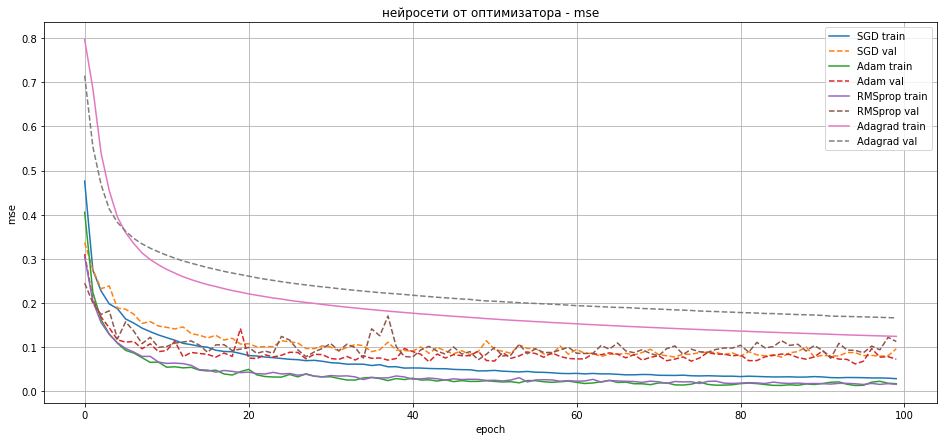

In [ ]:
# будем изменять оптимизаторы

# создаем модель model

model3 = Sequential()
model3.add(Dense(100, activation='relu', input_shape=(x_tr.shape[1],)))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(1, activation='linear'))

# сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
model3.save_weights('model31.h5')

plt.figure(figsize=(16,7))

epochs = 100
# вектор для выводв результатов
epoch = np.arange(epochs+1)

#opt_list = [keras.optimizers.SGD( ),keras.optimizers.Adam( ),keras.optimizers.Nadam( ), keras.optimizers.RMSProp( )]

for i_optim in ['SGD','adam', 'RMSProp','Adagrad',]:
  # создаем рабочую модель modeli куда будем загружать эти веса (она должна быть идентичной структуры)
  
  model31 = Sequential()
  model31.add(Dense(100, activation='relu', input_shape=(x_tr.shape[1],)))
  model31.add(Dense(100, activation='relu'))
  model31.add(Dense(1, activation='linear'))
  
  # загружаем веса modeli.load_weights('model.h5')
  model31.load_weights('model31.h5')
  
  model31.compile(optimizer= i_optim, loss='mse', metrics=metrics)

  hh = model31.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)
  
  metrics_list = metrics_list + [['1','100', 'mse', 'relu', i_optim , round(hh.history['loss'][-1], 3), round(model31.evaluate(x_test, y_test, verbose = 0)[1], 3)]]

  
  plt.plot(hh.history['mean_squared_error'],'-',label = model31.optimizer.get_config()['name']+' train')
  plt.plot(hh.history['val_mean_squared_error'],'--',label = model31.optimizer.get_config()['name']+' val')
plt.legend()
plt.grid('On')

plt.title('нейросети от оптимизатора - mse')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.show()

In [ ]:
df = pd.DataFrame(metrics_list, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mse','val_mse'], index =None)
df

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
0,1,900,mse,relu,adam,0.024,0.159
1,2,100,mse,relu,adam,0.014,0.164
2,3,100,mse,relu,adam,0.029,0.169
3,5,100,mse,relu,adam,0.027,0.148
4,10,100,mse,relu,adam,0.038,0.181
5,1,10,mse,relu,adam,0.095,0.183
6,1,50,mse,relu,adam,0.034,0.154
7,1,100,mse,relu,adam,0.026,0.142
8,1,400,mse,relu,adam,0.042,0.162
9,1,900,mse,relu,adam,0.022,0.163


SGD и Adam лучше отработали

In [ ]:
# функции активации
N = ['linear','relu', 'LeakyReLU', 'tanh', 'selu', 'sigmoid'] 
for i in N:
    model5 = Sequential() 
    model5.add(Dense(100, activation= 'relu', input_shape=(x_tr.shape[1],)))
    model5.add(Dense(100, activation = i)) 
    model5.add(Dense(1, activation='linear'))


    model5.compile(optimizer='adam',
                      loss='mse',
                      metrics=['mse', 'mae']) 

    history5 = model5.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)

    metrics_list = metrics_list + [['1', '100', 'mse', i, 'adam', round(history5.history['loss'][-1], 3), round(model5.evaluate(x_test, y_test, verbose = 0)[1], 3)]]

In [ ]:
df = pd.DataFrame(metrics_list, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mse','val_mse'], index =None)
df

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
0,1,900,mse,relu,adam,0.024,0.159
1,2,100,mse,relu,adam,0.014,0.164
2,3,100,mse,relu,adam,0.029,0.169
3,5,100,mse,relu,adam,0.027,0.148
4,10,100,mse,relu,adam,0.038,0.181
5,1,10,mse,relu,adam,0.095,0.183
6,1,50,mse,relu,adam,0.034,0.154
7,1,100,mse,relu,adam,0.026,0.142
8,1,400,mse,relu,adam,0.042,0.162
9,1,900,mse,relu,adam,0.022,0.163


лучше всего на тесте отработала sigmoid, LeakyReLU и linear активации

In [ ]:
#лучший результат на тесте
df.sort_values(by='val_mse')

,num_layers,n_neurons,loss,activation,optim,train_mse,val_mse
21,1,100,mse,sigmoid,adam,0.026,0.133
18,1,100,mse,LeakyReLU,adam,0.023,0.140
16,1,100,mse,linear,adam,0.026,0.140
7,1,100,mse,relu,adam,0.026,0.142
13,1,100,mse,relu,adam,0.017,0.143
12,1,100,mse,relu,SGD,0.028,0.143
3,5,100,mse,relu,adam,0.027,0.148
20,1,100,mse,selu,adam,0.022,0.153
6,1,50,mse,relu,adam,0.034,0.154
17,1,100,mse,relu,adam,0.021,0.156


In [ ]:
# поменяем лосс и метрику на mae
metrics_list_mae = []
N = ['linear','relu', 'LeakyReLU', 'tanh', 'selu', 'sigmoid'] 
for i in N:
    model5 = Sequential() 
    model5.add(Dense(100, activation= 'relu', input_shape=(x_tr.shape[1],)))
    model5.add(Dense(100, activation = i)) 
    model5.add(Dense(1, activation='linear'))


    model5.compile(optimizer='adam',
                      loss='mae',
                      metrics=['mae']) 

    history5 = model5.fit(x_tr, y_tr, batch_size=10, epochs=100, verbose=0, validation_split=0.2)

    metrics_list_mae = metrics_list_mae + [['1', '100', 'mae', i, 'adam', round(history5.history['loss'][-1], 3), round(model5.evaluate(x_test, y_test, verbose = 0)[1], 3)]]

In [ ]:
df = pd.DataFrame(metrics_list_mae, columns = ['num_layers', 'n_neurons', 'loss', 'activation', 'optim', 'train_mae','val_mae'], index =None)
df.sort_values(by='val_mae')

,num_layers,n_neurons,loss,activation,optim,train_mae,val_mae
2,1,100,mae,LeakyReLU,adam,0.090,0.257
4,1,100,mae,selu,adam,0.109,0.265
1,1,100,mae,relu,adam,0.077,0.268
3,1,100,mae,tanh,adam,0.097,0.272
5,1,100,mae,sigmoid,adam,0.116,0.283
0,1,100,mae,linear,adam,0.108,0.309


LeakyReLU показалу лучший результат на тесте

### **Ансамбль сетей**

Использование функционального API для построения сложных сетей

In [ ]:
# построим ансамбль, используем mae loss и mae метрику
input1 = keras.layers.Input(shape=(x_tr.shape[1],))
x1 = keras.layers.Dense(900, activation='relu')(input1)
x1 =keras.layers.Dense(1, activation='linear')(x1)
model11 =keras.models.Model(inputs=input1,outputs=x1)

input_2 = keras.layers.Input(shape=(x_tr.shape[1],))
x2 = keras.layers.Dense(256, activation='LeakyReLU')(input_2)
x2=keras.layers.Dense(1, activation='linear')(x2)
model22 =keras.models.Model(inputs=input_2,outputs=x2)

input_3 = keras.layers.Input(shape=(x_tr.shape[1],))
x3 = keras.layers.Dense(100, activation='sigmoid')(input_3)
x3=keras.layers.Dense(1, activation='linear')(x3)
model33 =keras.models.Model(inputs=[input_3],outputs=x3)


model11.compile(optimizer='sgd',
              loss='mse',
              metrics=['mse'])
model22.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mse'])
model33.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

hist1=model11.fit(x_tr, y_tr, epochs=100, batch_size=10, verbose=0)
hist2=model22.fit(x_tr, y_tr, epochs=100, batch_size=10, verbose=0)
hist3=model33.fit(x_tr, y_tr, epochs=100, batch_size=10, verbose=0)

# сохранить модели на диск.
model11.save_weights('model11.h5')
model22.save_weights('model22.h5')
model33.save_weights('model33.h5')



input1 = keras.layers.Input(shape=(x_tr.shape[1],))
x1 = keras.layers.Dense(900, activation='relu')(input1)
x1 =keras.layers.Dense(1, activation='linear')(x1)
model111 =keras.models.Model(inputs=input1,outputs=x1)

x2 = keras.layers.Dense(256, activation='LeakyReLU')(input1)
x2=keras.layers.Dense(1, activation='linear')(x2)
model222 =keras.models.Model(inputs=input1,outputs=x2)

x3 = keras.layers.Dense(100, activation='relu')(input1)
x3=keras.layers.Dense(1, activation='sigmoid')(x3)
model333 =keras.models.Model(inputs=[input1],outputs=x3)

# усредняем выходы сетей
out_all = keras.layers.Average()([model111.output,model222.output,model333.output])

model_all=keras.models.Model(inputs =[input1],outputs =out_all)
model_all.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

model111.load_weights('model11.h5')
model222.load_weights('model22.h5')
model333.load_weights('model33.h5')


In [ ]:
model_all.summary()

Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_75 (InputLayer)          [(None, 22)]         0           []                               
                                                                                                  
 dense_872 (Dense)              (None, 900)          20700       ['input_75[0][0]']               
                                                                                                  
 dense_874 (Dense)              (None, 256)          5888        ['input_75[0][0]']               
                                                                                                  
 dense_876 (Dense)              (None, 100)          2300        ['input_75[0][0]']               
                                                                                           

In [ ]:
from tensorflow.keras.utils import plot_model

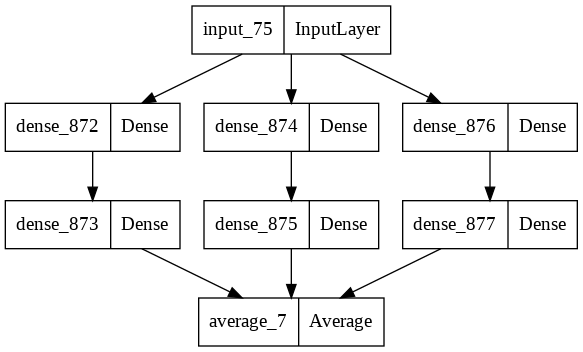

In [ ]:
plot_model(model_all,to_file='new_model-all.png')

In [ ]:
print(model11.evaluate(x_test, y_test, verbose=2))
print(model22.evaluate(x_test, y_test, verbose=2))
print(model33.evaluate(x_test, y_test, verbose=2))

4/4 - 0s - loss: 0.1336 - mse: 0.1336 - 101ms/epoch - 25ms/step
[0.1336262822151184, 0.1336262822151184]
4/4 - 0s - loss: 0.1578 - mse: 0.1578 - 96ms/epoch - 24ms/step
[0.15778739750385284, 0.15778739750385284]
4/4 - 0s - loss: 0.1834 - mse: 0.1834 - 114ms/epoch - 29ms/step
[0.18344996869564056, 0.18344996869564056]


In [ ]:
model_all.evaluate(x_test, y_test, verbose=2)

4/4 - 0s - loss: 0.2178 - mse: 0.2178 - 209ms/epoch - 52ms/step


[0.2177526205778122, 0.2177526205778122]

ансамбль показал хуже результат, чем простые сети

по всем моделям лучший mse на трейне получен 0,014, и
на тесте - 0,133

В целом наибольшее значение имели количество нейронов и количество слоев (1 слой дал отличный результат). Протестированные оптимизаторы дают похожий результат. Функцию активации нужно подбирать.


  

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  хороший результат дала активация tf.keras.layers.LeakyReLU
  для нормализации данных можно использовать слой tf.keras.layers.Normalization и tf.keras.layers.BatchNormalization
  